# Multivariable Prediction TF LSTM


In [1]:
## Import libraries

In [31]:
#Import libraries

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import AdamW
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from keras.layers import Dropout
from tensorflow_addons.optimizers import AdamW  # Import AdamW
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# User Inputs

In [32]:
fab_path = "/Users/badeesh/Desktop/AIML/alam_dataset/jul5/fabric_stats.csv"
int_path = "/Users/badeesh/Desktop/AIML/alam_dataset/jul5/interface_stats.csv"
ratio_error_threshold = 0.98
pfe_spec = 'FPC0:PIC0:NPU0:DP0'
wan_map = ['et-0/0/9','et-0/0/11', 'et-0/0/13', 'et-0/0/15']
rate_bps_lower_limit = 0
rate_bps_upper_limit = 1.8e12
anamolies_path = ''

# Data Loading

In [33]:
# Load datasets

sampling_time = 60
# Load the data from the CSV file
df_fabric = pd.read_csv(fab_path)
df_fabric['time'] = pd.to_datetime(df_fabric['time'], unit='ns')
df_fabric.set_index('time', inplace=True)
# Format timestamp to display only date, hours, and minutes
df_fabric['formatted_time'] = df_fabric.index.strftime('%Y-%m-%d %H:%M:%S')
df_fabric['formatted_time2'] = df_fabric.index.strftime('%Y-%m-%d %H:%M')
pfe_spec = 'FPC0:PIC0:NPU0:DP0'
df_fabric = df_fabric[df_fabric['fru'] == pfe_spec]
df_fabric= df_fabric[(df_fabric['out-rate-bps'] > rate_bps_lower_limit) & (df_fabric['out-rate-bps'] < rate_bps_upper_limit)]
df_fabric[['formatted_time','formatted_time2','fru','out-rate-bps']]


,formatted_time,formatted_time2,fru,out-rate-bps
time,,,,
2023-06-30 17:31:53.695656951,2023-06-30 17:31:53,2023-06-30 17:31,FPC0:PIC0:NPU0:DP0,5120
2023-06-30 19:12:11.498046134,2023-06-30 19:12:11,2023-06-30 19:12,FPC0:PIC0:NPU0:DP0,1588457504768
2023-06-30 19:14:11.493288210,2023-06-30 19:14:11,2023-06-30 19:14,FPC0:PIC0:NPU0:DP0,1588826210304
2023-06-30 19:15:11.492712348,2023-06-30 19:15:11,2023-06-30 19:15,FPC0:PIC0:NPU0:DP0,1588622917632
2023-06-30 19:16:11.490832908,2023-06-30 19:16:11,2023-06-30 19:16,FPC0:PIC0:NPU0:DP0,1586672304128
...,...,...,...,...
2023-07-05 22:30:49.500361888,2023-07-05 22:30:49,2023-07-05 22:30,FPC0:PIC0:NPU0:DP0,494484062208
2023-07-05 22:31:49.496063559,2023-07-05 22:31:49,2023-07-05 22:31,FPC0:PIC0:NPU0:DP0,844184223744
2023-07-05 22:32:49.498041889,2023-07-05 22:32:49,2023-07-05 22:32,FPC0:PIC0:NPU0:DP0,633697992704


In [34]:

# Load the data from the CSV file
df_interface = pd.read_csv(int_path)
df_interface['time'] = pd.to_datetime(df_interface['time'], unit='ns')
df_interface.set_index('time', inplace=True)
df_interface['formatted_time'] = df_interface.index.strftime('%Y-%m-%d %H:%M:%S')
df_interface['formatted_time2'] = df_interface.index.strftime('%Y-%m-%d %H:%M')
wan_inputs = ['et-0/0/9', 'et-0/0/11', 'et-0/0/13', 'et-0/0/15']
df_interface = df_interface[df_interface['name.1'].isin(wan_inputs)]
# df_interface

In [35]:
# Pivot the table using 'name.1' values as columns and 'output-bps' values to fill them
df_interface_pivoted = df_interface.pivot(index='formatted_time', columns='name.1', values='input-bps')

In [36]:
df_fabric

,name,__device_timestamp__,_instance_id,_playbook_name,fru,in-bytes,in-rate-bps,out-bytes,out-rate-bps,tandIngestTimestamp,tandTimeOffset,formatted_time,formatted_time2
time,,,,,,,,,,,,,
2023-06-30 17:31:53.695656951,fabric/utilization,1688146313593,"[""jun28""]",fabutil,FPC0:PIC0:NPU0:DP0,258608,3584,369440,5120,1688146313628464536,67.192415ms,2023-06-30 17:31:53,2023-06-30 17:31
2023-06-30 19:12:11.498046134,fabric/utilization,1688152331040,"[""jun30""]",fabutil,FPC0:PIC0:NPU0:DP0,22970554786304,1588462616576,2799023585808,1588457504768,1688152331079382159,418.663975ms,2023-06-30 19:12:11,2023-06-30 19:12
2023-06-30 19:14:11.493288210,fabric/utilization,1688152451040,"[""jun30""]",fabutil,FPC0:PIC0:NPU0:DP0,9392789294768,1588831322112,14509949182048,1588826210304,1688152451054462287,438.825923ms,2023-06-30 19:14:11,2023-06-30 19:14
2023-06-30 19:15:11.492712348,fabric/utilization,1688152511040,"[""jun30""]",fabutil,FPC0:PIC0:NPU0:DP0,21294280742160,1588628291584,14316785223664,1588622917632,1688152511053400478,439.31187ms,2023-06-30 19:15:11,2023-06-30 19:15
2023-06-30 19:16:11.490832908,fabric/utilization,1688152571044,"[""jun30""]",fabutil,FPC0:PIC0:NPU0:DP0,9006541335088,1586669027328,14123647159632,1586672304128,1688152571057908770,432.924138ms,2023-06-30 19:16:11,2023-06-30 19:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-05 22:30:49.500361888,fabric/utilization,1688596248590,"[""jun30""]",fabutil,FPC0:PIC0:NPU0:DP0,32914910807488,474280951808,23392612280400,494484062208,1688596248650319928,850.04196ms,2023-07-05 22:30:49,2023-07-05 22:30
2023-07-05 22:31:49.496063559,fabric/utilization,1688596308590,"[""jun30""]",fabutil,FPC0:PIC0:NPU0:DP0,36472839689824,631842865152,16028102512048,844184223744,1688596308626809445,869.254114ms,2023-07-05 22:31:49,2023-07-05 22:31
2023-07-05 22:32:49.498041889,fabric/utilization,1688596368594,"[""jun30""]",fabutil,FPC0:PIC0:NPU0:DP0,33440236092944,633697468416,20782447197008,633697992704,1688596368649818359,848.22353ms,2023-07-05 22:32:49,2023-07-05 22:32


In [37]:
df_fabric_pivoted = df_fabric.pivot(index='formatted_time', columns='fru', values='out-rate-bps')

In [38]:
df_fabric_pivoted

fru,FPC0:PIC0:NPU0:DP0
formatted_time,
2023-06-30 17:31:53,5120
2023-06-30 19:12:11,1588457504768
2023-06-30 19:14:11,1588826210304
2023-06-30 19:15:11,1588622917632
2023-06-30 19:16:11,1586672304128
...,...
2023-07-05 22:30:49,494484062208
2023-07-05 22:31:49,844184223744
2023-07-05 22:32:49,633697992704


In [39]:
# Select the columns to sum
columns_to_sum = wan_map

# Create a new column with the sum of values
df_interface_pivoted['sum_of_et_inputs'] = df_interface_pivoted[columns_to_sum].sum(axis=1)

df_interface_pivoted

name.1,et-0/0/11,et-0/0/13,et-0/0/15,et-0/0/9,sum_of_et_inputs
formatted_time,,,,,
2023-06-30 17:31:44,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2023-06-30 19:12:22,3.943930e+11,3.943940e+11,3.943926e+11,3.943968e+11,1.577576e+12
2023-06-30 19:13:21,3.945238e+11,3.945261e+11,3.945231e+11,3.945232e+11,1.578096e+12
2023-06-30 19:14:21,3.941552e+11,3.941547e+11,3.941583e+11,3.941532e+11,1.576621e+12
2023-06-30 19:15:21,3.941605e+11,3.941591e+11,3.941593e+11,3.941600e+11,1.576639e+12
...,...,...,...,...,...
2023-07-05 22:31:21,1.178673e+11,1.178673e+11,1.178667e+11,1.178682e+11,4.714695e+11
2023-07-05 22:32:21,1.574042e+11,1.574047e+11,1.574057e+11,1.574031e+11,6.296177e+11
2023-07-05 22:33:21,1.575344e+11,1.575347e+11,1.575341e+11,1.575344e+11,6.301377e+11


In [37]:
import pandas as pd

# Assuming you have df_fabric_pivoted and df_interface_pivoted already created
# df_fabric_pivoted = ...
# df_interface_pivoted = ...

# Convert the index of both DataFrames to datetime format
df_fabric_pivoted.index = pd.to_datetime(df_fabric_pivoted.index)
df_interface_pivoted.index = pd.to_datetime(df_interface_pivoted.index)

# Extract the '%Y-%m-%d %H:%M' component from the index and convert to string
df_fabric_pivoted['time_component'] = df_fabric_pivoted.index.strftime('%Y-%m-%d %H:%M')
df_interface_pivoted['time_component'] = df_interface_pivoted.index.strftime('%Y-%m-%d %H:%M')

# Merge the DataFrames using the 'time_component' column
merged_df = df_fabric_pivoted.merge(df_interface_pivoted, on='time_component', how='inner')

merged_df['ratio'] = merged_df['FPC0:PIC0:NPU0:DP0']/merged_df['sum_of_et_inputs']
# Remove rows with NaN values
merged_df.dropna(inplace=True)
print(merged_df)


      FPC0:PIC0:NPU0:DP0    time_component     et-0/0/11     et-0/0/13  \
0                   5120  2023-06-30 17:31  0.000000e+00  0.000000e+00   
1          1588457504768  2023-06-30 19:12  3.943930e+11  3.943940e+11   
2          1588826210304  2023-06-30 19:14  3.941552e+11  3.941547e+11   
3          1588622917632  2023-06-30 19:15  3.941605e+11  3.941591e+11   
4          1586672304128  2023-06-30 19:16  3.940130e+11  3.940101e+11   
...                  ...               ...           ...           ...   
6911        494484062208  2023-07-05 22:30  1.179383e+11  1.179387e+11   
6912        844184223744  2023-07-05 22:31  1.178673e+11  1.178673e+11   
6913        633697992704  2023-07-05 22:32  1.574042e+11  1.574047e+11   
6914        633637371904  2023-07-05 22:33  1.575344e+11  1.575347e+11   
6915        633773883392  2023-07-05 22:34  1.575545e+11  1.575544e+11   

         et-0/0/15      et-0/0/9  sum_of_et_inputs     ratio  
0     0.000000e+00  0.000000e+00      0.000000e+

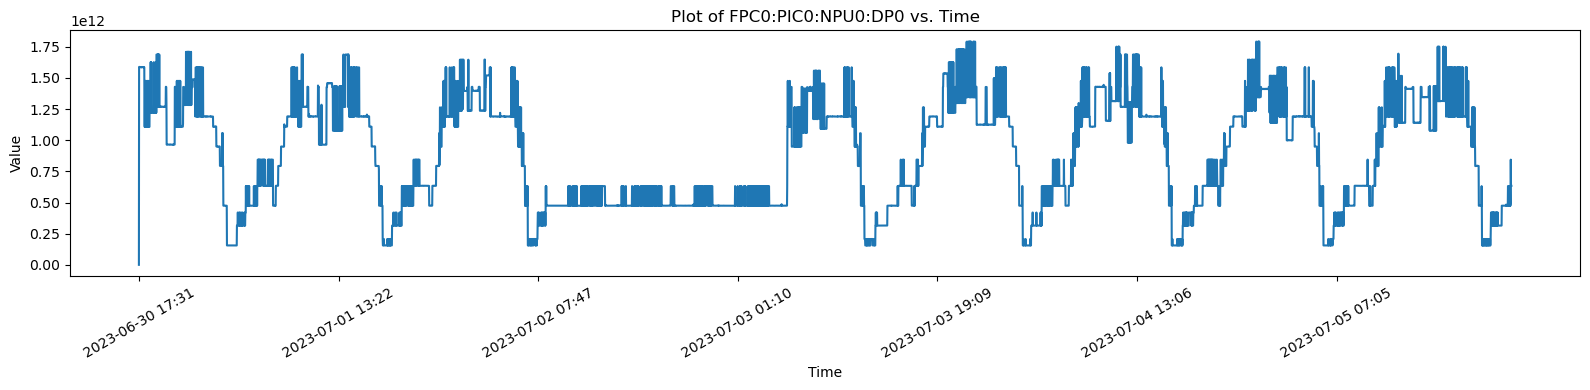

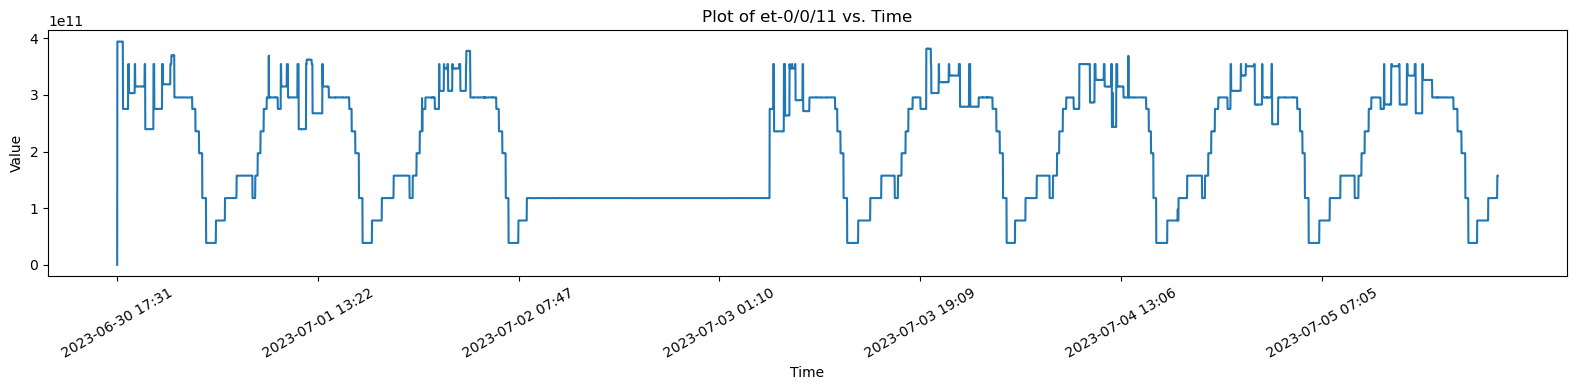

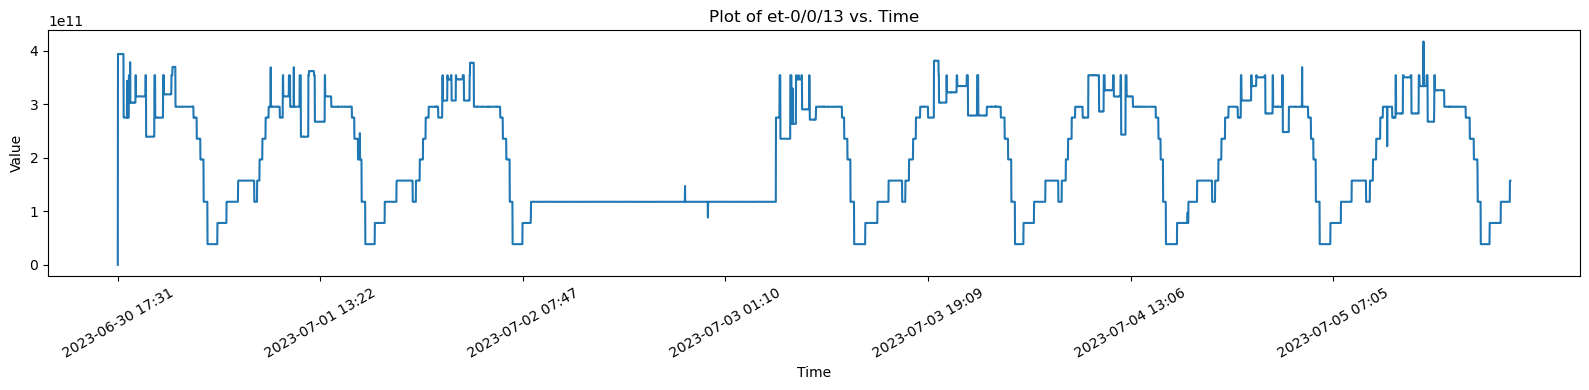

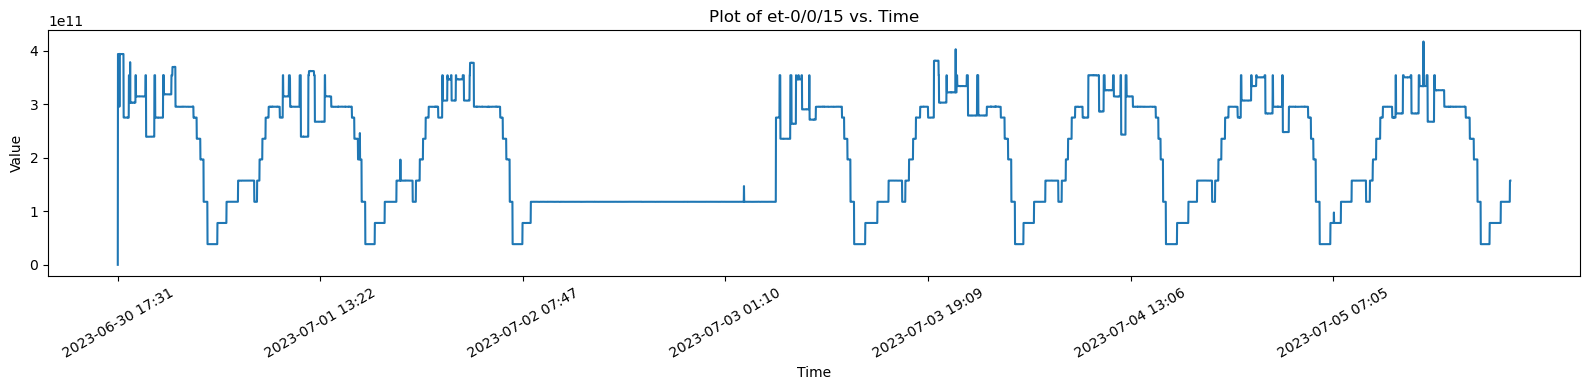

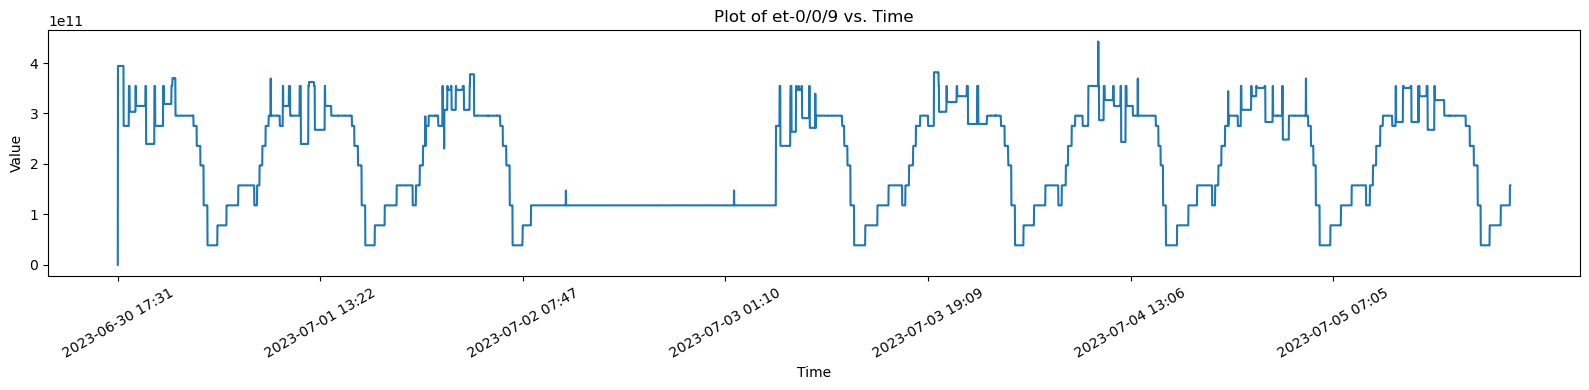

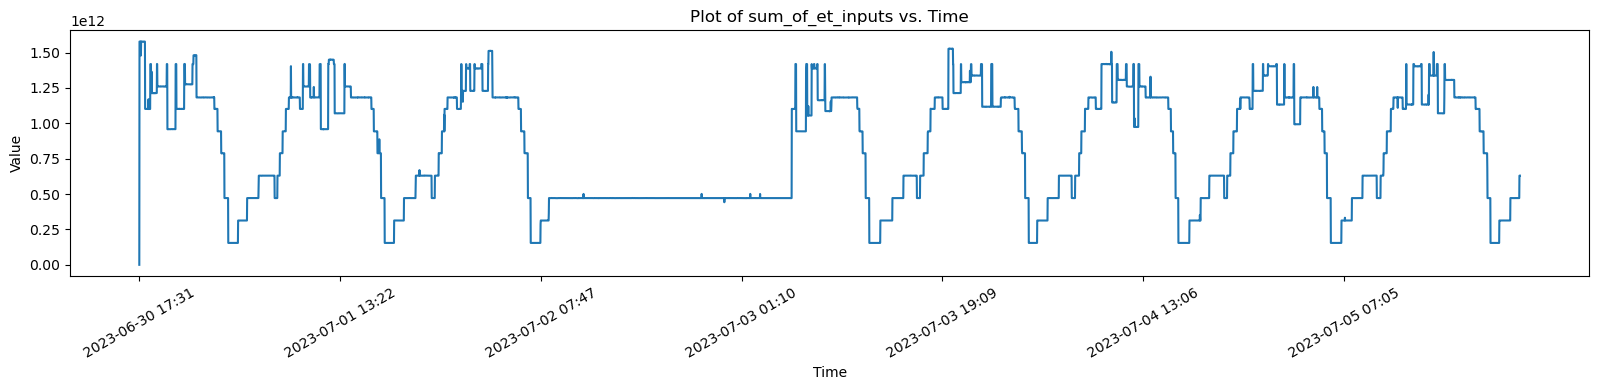

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the index of both DataFrames to datetime format
df_fabric_pivoted.index = pd.to_datetime(df_fabric_pivoted.index)
df_interface_pivoted.index = pd.to_datetime(df_interface_pivoted.index)

# Extract the '%Y-%m-%d %H:%M' component from the index and convert to string
df_fabric_pivoted['time_component'] = df_fabric_pivoted.index.strftime('%Y-%m-%d %H:%M')
df_interface_pivoted['time_component'] = df_interface_pivoted.index.strftime('%Y-%m-%d %H:%M')

# Combine the two DataFrames using the 'time_component' column as the index
combined_df = df_fabric_pivoted.merge(df_interface_pivoted, on='time_component', how='inner')
# Remove rows with NaN values
combined_df.dropna(inplace=True)

# Plot each column against 'time_component'
columns_to_plot = combined_df.columns.difference(['time_component'])

for column in columns_to_plot:
    plt.figure(figsize=(16, 4))  # Set the figure size for each plot
    plt.plot(combined_df['time_component'], combined_df[column])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Plot of {column} vs. Time')
    x_ticks = combined_df['time_component'][::1000]  # Select every 1000th value
    plt.xticks(x_ticks, rotation=30)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()


# Plotting Fabric: Out-bps vs Interface WAN Input sum

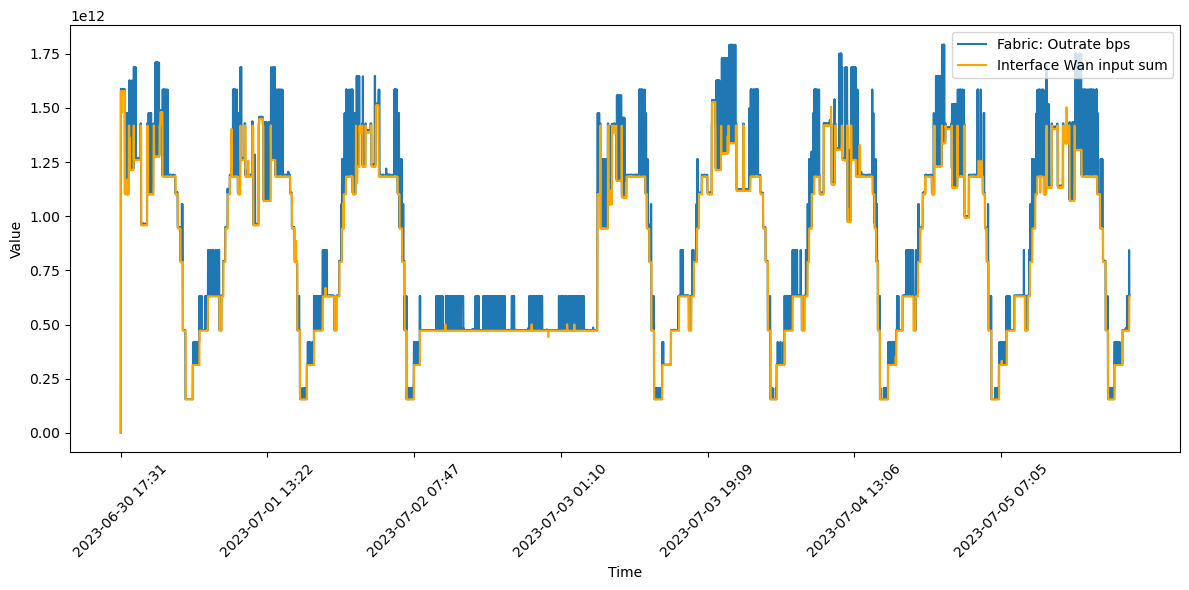

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine the two DataFrames using the 'time_component' column as the index
combined_df = df_fabric_pivoted.merge(df_interface_pivoted, on='time_component', how='inner')
# Remove rows with NaN values
combined_df.dropna(inplace=True)

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot 'FPC0:PIC0:NPU0:DP0' column
ax.plot(combined_df['time_component'], combined_df['FPC0:PIC0:NPU0:DP0'], label='Fabric: Outrate bps')
ax.plot(combined_df['time_component'], combined_df['sum_of_et_inputs'], label='Interface Wan input sum', color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
x_ticks = combined_df['time_component'][::1000]  # Select every 1000th value
plt.xticks(x_ticks, rotation=45)  # Rotate x-axis labels for better visibility

# Adjust layout
plt.tight_layout()
plt.show()


# Plotting Ratio of Fabric: Out-bps vs Interface WAN Input sum

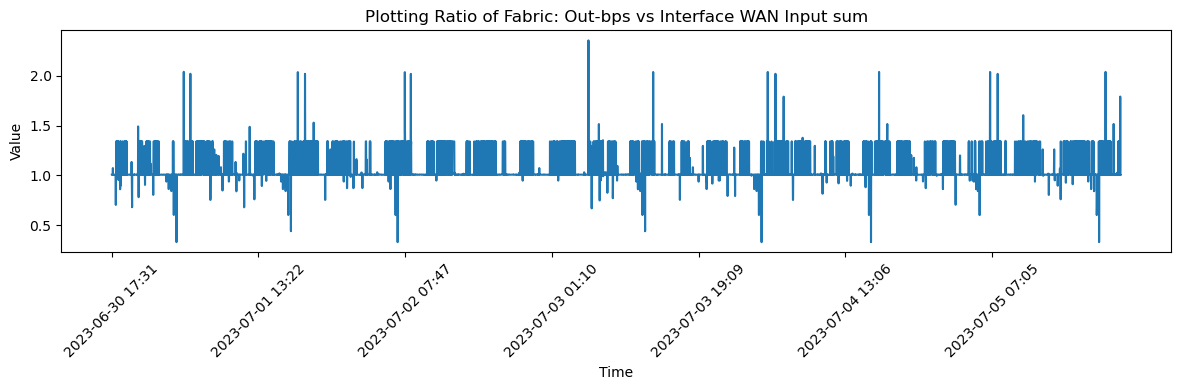

In [43]:
plt.figure(figsize=(12, 4))  # Set the figure size for each plot
plt.plot(merged_df['time_component'], merged_df['ratio'])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Plotting Ratio of Fabric: Out-bps vs Interface WAN Input sum')
x_ticks = combined_df['time_component'][::1000]  # Select every 1000th value
plt.xticks(x_ticks, rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

# Anamoly Detection

In [28]:
merged_df[merged_df['ratio']<0.98]

,FPC0:PIC0:NPU0:DP0,time_component,et-0/0/11,et-0/0/13,et-0/0/15,et-0/0/9,sum_of_et_inputs,ratio
28,1108923777024,2023-06-30 19:47,3.942741e+11,3.942675e+11,3.942588e+11,3.942761e+11,1.577077e+12,0.703152
46,1115920138240,2023-06-30 20:05,2.753200e+11,3.441487e+11,2.752952e+11,2.753191e+11,1.170083e+12,0.953710
57,1220359618560,2023-06-30 20:16,3.545106e+11,3.545117e+11,3.545104e+11,3.545127e+11,1.418045e+12,0.860593
58,1221551980544,2023-06-30 20:17,3.546096e+11,3.546112e+11,3.546097e+11,3.546108e+11,1.418441e+12,0.861193
61,1221527732224,2023-06-30 20:20,3.031558e+11,3.790212e+11,3.790200e+11,3.031631e+11,1.364360e+12,0.895312
...,...,...,...,...,...,...,...,...
6712,948449050624,2023-07-05 19:00,2.751467e+11,2.751442e+11,2.751439e+11,2.751465e+11,1.100581e+12,0.861771
6732,792867766272,2023-07-05 19:20,2.357972e+11,2.357943e+11,2.357947e+11,2.357973e+11,9.431836e+11,0.840629
6750,474224984064,2023-07-05 19:40,1.970848e+11,1.970850e+11,1.970846e+11,1.970850e+11,7.883394e+11,0.601549
6751,474158366720,2023-07-05 19:41,1.971918e+11,1.715731e+11,1.179290e+11,1.971923e+11,6.838862e+11,0.693329


# Hard Thresholding 

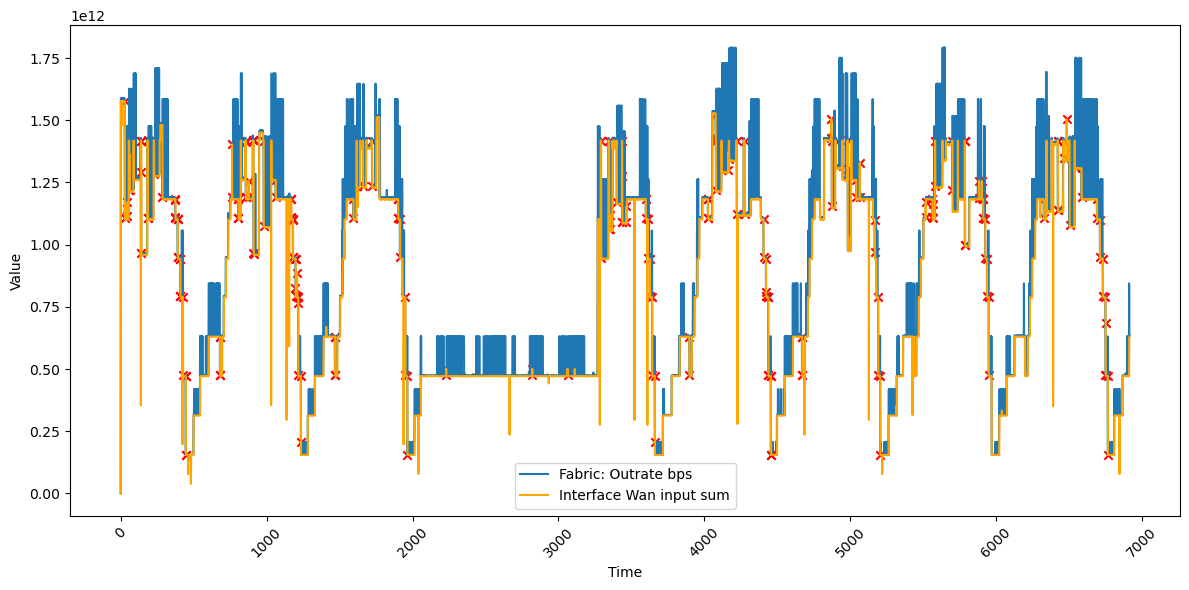

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot 'FPC0:PIC0:NPU0:DP0' column
ax.plot(merged_df.index, merged_df['FPC0:PIC0:NPU0:DP0'], label='Fabric: Outrate bps')
ax.plot(merged_df.index, merged_df['sum_of_et_inputs'], label='Interface Wan input sum', color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

# Rotate x-axis labels for better visibility
x_ticks = combined_df['time_component'][::1000]  # Select every 1000th value
plt.xticks(rotation=45)

# Add anomaly points
anomalies = merged_df[merged_df['ratio'] < ratio_error_threshold]
ax.scatter(anomalies.index, anomalies['FPC0:PIC0:NPU0:DP0'], marker='x', color='red', label='Anomaly')
ax.scatter(anomalies.index, anomalies['sum_of_et_inputs'], marker='x', color='red')  # Anomaly in the other column

# Adjust layout
plt.tight_layout()
plt.show()

In [30]:
anomalies

,FPC0:PIC0:NPU0:DP0,time_component,et-0/0/11,et-0/0/13,et-0/0/15,et-0/0/9,sum_of_et_inputs,ratio
28,1108923777024,2023-06-30 19:47,3.942741e+11,3.942675e+11,3.942588e+11,3.942761e+11,1.577077e+12,0.703152
46,1115920138240,2023-06-30 20:05,2.753200e+11,3.441487e+11,2.752952e+11,2.753191e+11,1.170083e+12,0.953710
57,1220359618560,2023-06-30 20:16,3.545106e+11,3.545117e+11,3.545104e+11,3.545127e+11,1.418045e+12,0.860593
58,1221551980544,2023-06-30 20:17,3.546096e+11,3.546112e+11,3.546097e+11,3.546108e+11,1.418441e+12,0.861193
61,1221527732224,2023-06-30 20:20,3.031558e+11,3.790212e+11,3.790200e+11,3.031631e+11,1.364360e+12,0.895312
...,...,...,...,...,...,...,...,...
6712,948449050624,2023-07-05 19:00,2.751467e+11,2.751442e+11,2.751439e+11,2.751465e+11,1.100581e+12,0.861771
6732,792867766272,2023-07-05 19:20,2.357972e+11,2.357943e+11,2.357947e+11,2.357973e+11,9.431836e+11,0.840629
6750,474224984064,2023-07-05 19:40,1.970848e+11,1.970850e+11,1.970846e+11,1.970850e+11,7.883394e+11,0.601549
6751,474158366720,2023-07-05 19:41,1.971918e+11,1.715731e+11,1.179290e+11,1.971923e+11,6.838862e+11,0.693329


In [31]:
# Save the DataFrame to a CSV file
anomalies.to_csv('anomalies.csv', index=False)

# Bursty Anamoly

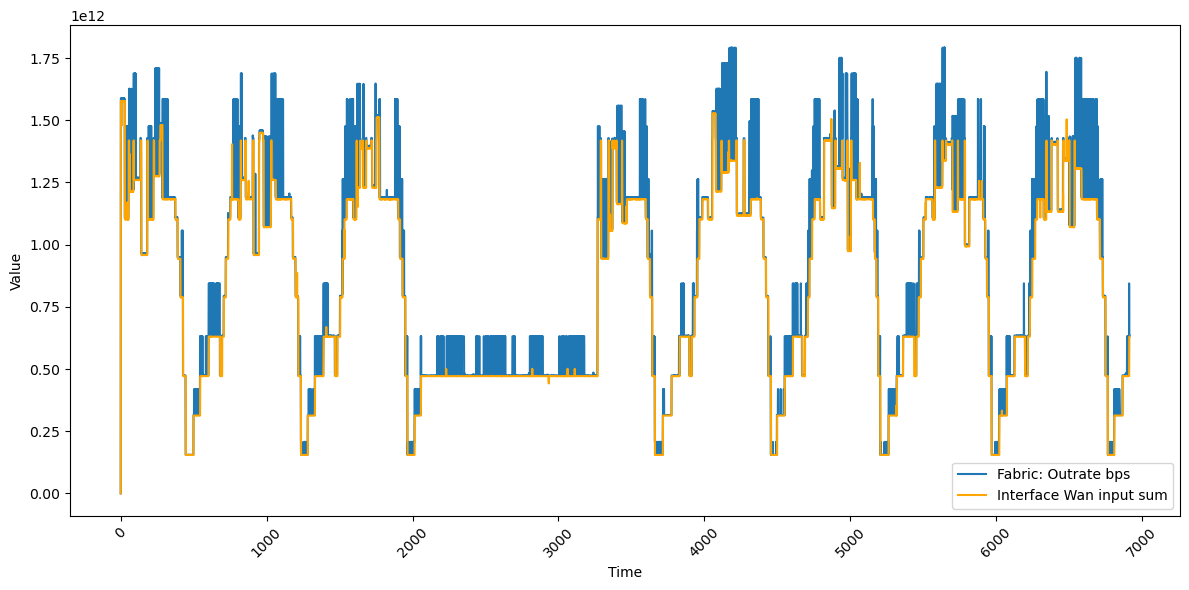

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Find consecutive bursty anomalies
bursty_anomalies = []
consecutive_count = 0
for index, row in merged_df.iterrows():
    if row['ratio'] < ratio_error_threshold:
        consecutive_count += 1
        if consecutive_count >= 3:
            bursty_anomalies.append(index)
    else:
        consecutive_count = 0

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot 'FPC0:PIC0:NPU0:DP0' column
ax.plot(merged_df.index, merged_df['FPC0:PIC0:NPU0:DP0'], label='Fabric: Outrate bps')
ax.plot(merged_df.index, merged_df['sum_of_et_inputs'], label='Interface Wan input sum', color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

# Rotate x-axis labels for better visibility
x_ticks = combined_df['time_component'][::1000]  # Select every 1000th value
plt.xticks(rotation=45)

# Mark bursty anomalies with 'x' markers
ax.scatter(bursty_anomalies, merged_df.loc[bursty_anomalies, 'FPC0:PIC0:NPU0:DP0'],
           marker='x', color='red', label='Bursty Anomaly')

# Adjust layout
plt.tight_layout()
plt.show()


In [39]:
bursty_anomalies

[]

# Sliding Window

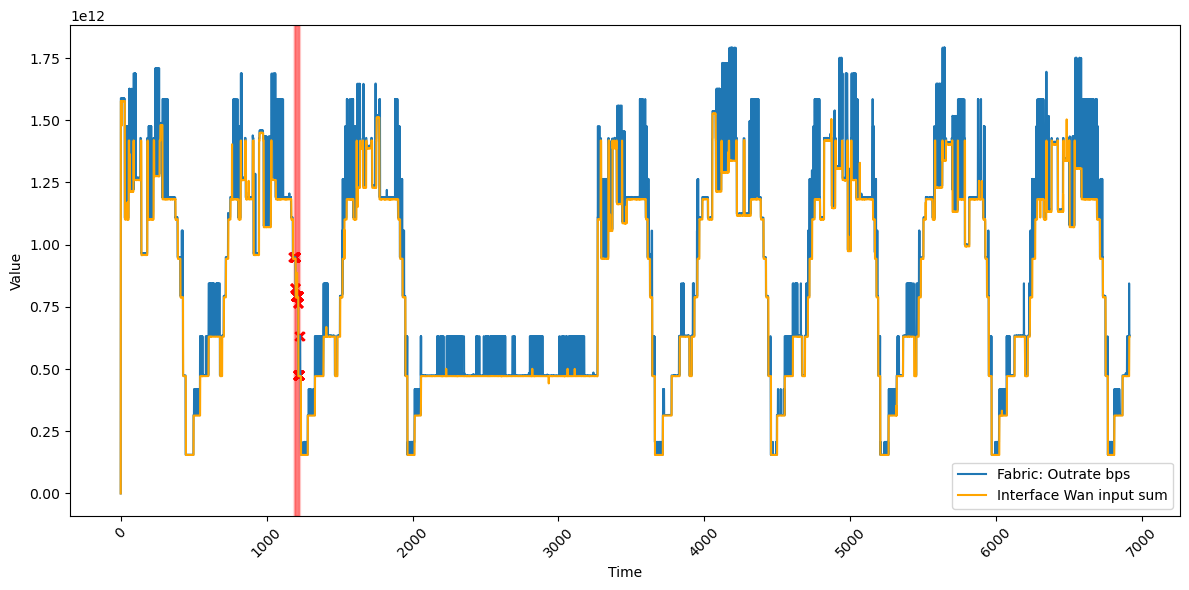

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define the window size and anomaly threshold
window_size = 30
anomaly_threshold = 5

# Find sliding window anomalies
sliding_window_anomalies = []
anomaly_windows = []  # To store the start index of anomalous windows
for i in range(len(merged_df) - window_size + 1):
    window = merged_df.iloc[i : i + window_size]
    num_anomalies = (window['ratio'] < 0.98).sum()
    if num_anomalies >= anomaly_threshold:
        sliding_window_anomalies.extend(window.index)
        anomaly_windows.append(i)

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot 'FPC0:PIC0:NPU0:DP0' column
ax.plot(merged_df.index, merged_df['FPC0:PIC0:NPU0:DP0'], label='Fabric: Outrate bps')
ax.plot(merged_df.index, merged_df['sum_of_et_inputs'], label='Interface Wan input sum', color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

# Rotate x-axis labels for better visibility
x_ticks = combined_df['time_component'][::1000]  # Select every 1000th value
plt.xticks(rotation=45)

# Mark sliding window anomalies with 'x' markers
ax.scatter(sliding_window_anomalies, merged_df.loc[sliding_window_anomalies, 'FPC0:PIC0:NPU0:DP0'],
           marker='x', color='red', label='Sliding Window Anomaly')

# Highlight the anomalous windows
for window_start in anomaly_windows:
    plt.axvspan(merged_df.index[window_start], merged_df.index[window_start + window_size - 1],
                color='red', alpha=0.05)
#     plt.text(merged_df.index[window_start], ax.get_ylim()[1], f'Anomaly Window',
#              rotation=45, color='red', fontsize=8)

# Adjust layout
plt.tight_layout()
plt.show()


# Catch High Ratios 

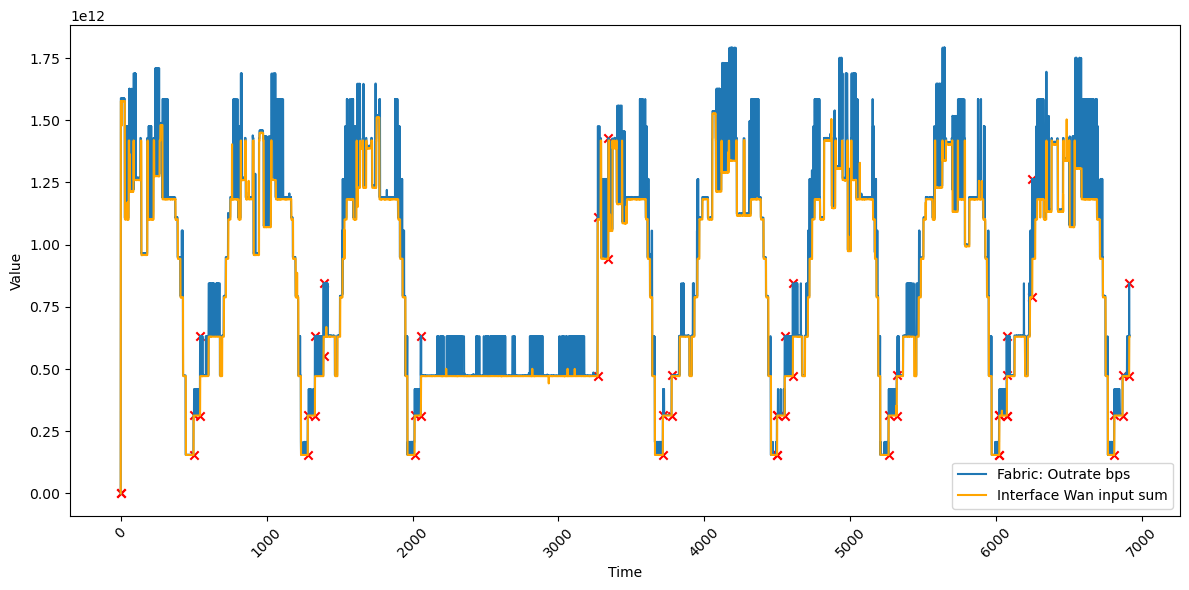

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot 'FPC0:PIC0:NPU0:DP0' column
ax.plot(merged_df.index, merged_df['FPC0:PIC0:NPU0:DP0'], label='Fabric: Outrate bps')
ax.plot(merged_df.index, merged_df['sum_of_et_inputs'], label='Interface Wan input sum', color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

# Rotate x-axis labels for better visibility
x_ticks = combined_df['time_component'][::1000]  # Select every 1000th value
plt.xticks(rotation=45)

# Add anomaly points
anomalies = merged_df[merged_df['ratio'] > 1.5]
ax.scatter(anomalies.index, anomalies['FPC0:PIC0:NPU0:DP0'], marker='x', color='red', label='Anomaly')
ax.scatter(anomalies.index, anomalies['sum_of_et_inputs'], marker='x', color='red')  # Anomaly in the other column

# Adjust layout
plt.tight_layout()
plt.show()

In [51]:
anomalies


,FPC0:PIC0:NPU0:DP0,time_component,et-0/0/11,et-0/0/13,et-0/0/15,et-0/0/9,sum_of_et_inputs,ratio
0,5120,2023-06-30 17:31,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,inf
499,315110981632,2023-07-01 04:20,3.863841e+10,3.863813e+10,3.863801e+10,3.863818e+10,1.545527e+11,2.038858
544,632080236544,2023-07-01 05:05,7.824857e+10,7.824826e+10,7.824826e+10,7.824872e+10,3.129938e+11,2.019466
1282,314774749184,2023-07-01 18:02,3.865423e+10,3.865397e+10,3.865401e+10,3.865446e+10,1.546167e+11,2.035840
1331,631713693696,2023-07-01 18:51,7.822613e+10,7.822583e+10,7.822584e+10,7.822595e+10,3.129038e+11,2.018875
1390,843882692608,2023-07-01 19:50,1.236385e+11,1.529908e+11,1.574641e+11,1.178563e+11,5.519497e+11,1.528912
2014,314866204672,2023-07-02 07:45,3.867069e+10,3.867173e+10,3.867278e+10,3.866964e+10,1.546848e+11,2.035534
2057,631749345280,2023-07-02 08:28,7.825094e+10,7.825144e+10,7.825161e+10,7.825093e+10,3.130049e+11,2.018337
3269,1109548466176,2023-07-03 05:22,1.178361e+11,1.178357e+11,1.178352e+11,1.178363e+11,4.713433e+11,2.354014
3342,1428270612480,2023-07-03 06:36,2.357584e+11,2.357587e+11,2.357608e+11,2.357555e+11,9.430334e+11,1.514549


In [52]:
len(anomalies)

26